<a href="https://colab.research.google.com/github/ikram-maulanaadnan/ML-ACCOUNTANT-DUMMY/blob/main/ACCOUNTANT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np

data = {
    "transaction_id": range(1, 11),
    "date": pd.date_range(start="2025-01-01", periods=10, freq="D"),
    "amount": [1200, -100, -500, -50, 500, -300, -150, 700, -250, 100],
    "account_type": ["savings", "current", "current", "savings", "current", "current", "savings", "current", "savings", "current"],
    "transaction_type": ["transfer", "withdrawal", "transfer", "payment", "deposit", "payment", "withdrawal", "deposit", "payment", "transfer"],
    "vendor": ["ABC Corp", "ATM", "XYZ Ltd", "Netflix", "ABC Corp", "Spotify", "ATM", "Company B", "Google", "XYZ Ltd"],
    "balance": [15000, 14900, 14400, 14350, 14850, 14550, 14400, 15100, 14850, 14950],
    "description": ["salary", "atm", "utilities", "streaming", "bonus", "music", "cash", "invoice", "ads", "utilities"]
}
df = pd.DataFrame(data)
df.to_csv("accounting_data.csv", index=False)
df.head()


,transaction_id,date,amount,account_type,transaction_type,vendor,balance,description
0,1,2025-01-01,1200,savings,transfer,ABC Corp,15000,salary
1,2,2025-01-02,-100,current,withdrawal,ATM,14900,atm
2,3,2025-01-03,-500,current,transfer,XYZ Ltd,14400,utilities
3,4,2025-01-04,-50,savings,payment,Netflix,14350,streaming
4,5,2025-01-05,500,current,deposit,ABC Corp,14850,bonus


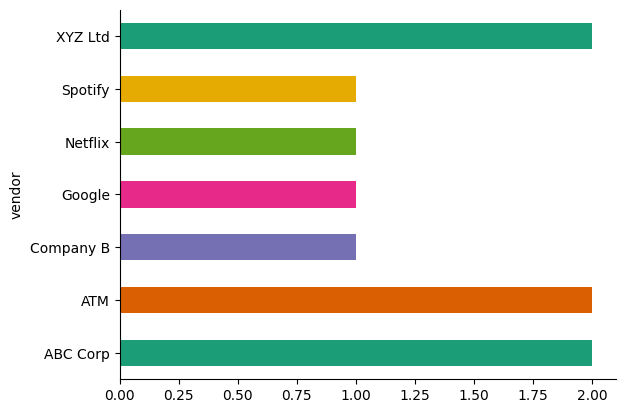

In [12]:
# @title vendor

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('vendor').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

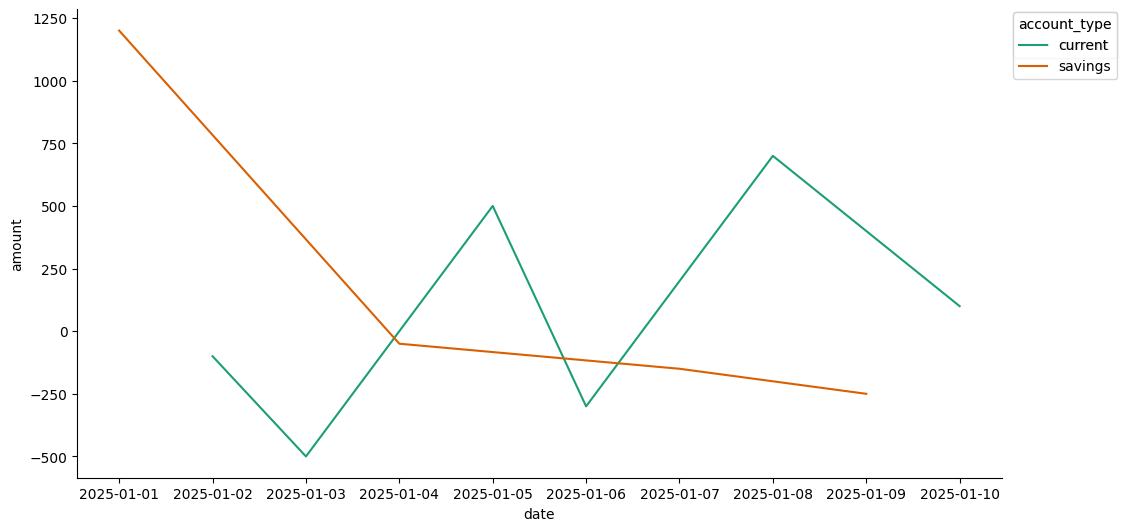

In [13]:
# @title date vs amount

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['amount']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('account_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='account_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('amount')

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

y_class = df['transaction_type']
y_amount = df['amount']

X = df[['amount', 'balance', 'account_type', 'vendor', 'day', 'month', 'year']]

numerical = ['amount', 'balance', 'day', 'month', 'year']
categorical = ['account_type', 'vendor']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

X_proc = preprocessor.fit_transform(X)

label_encoder = LabelEncoder()
y_class_enc = label_encoder.fit_transform(y_class)

X_train, X_test, y_class_train, y_class_test, y_amount_train, y_amount_test = train_test_split(
    X_proc, y_class_enc, y_amount, test_size=0.2, random_state=42
)

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

y_class = df['transaction_type']
y_amount = df['amount']

X = df[['amount', 'balance', 'account_type', 'vendor', 'day', 'month', 'year']]

numerical = ['amount', 'balance', 'day', 'month', 'year']
categorical = ['account_type', 'vendor']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

X_proc = preprocessor.fit_transform(X)

label_encoder = LabelEncoder()
y_class_enc = label_encoder.fit_transform(y_class)

X_train, X_test, y_class_train, y_class_test, y_amount_train, y_amount_test = train_test_split(
    X_proc, y_class_enc, y_amount, test_size=0.2, random_state=42
)

In [16]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]
inp = Input(shape=(input_dim,))
x = Dense(64, activation='relu')(inp)
x = Dense(32, activation='relu')(x)

out_class = Dense(len(np.unique(y_class_enc)), activation='softmax', name='classification')(x)
out_reg = Dense(1, activation='linear', name='prediction')(x)

encoded = Dense(16, activation='relu')(x)
decoded = Dense(input_dim, activation='sigmoid', name='reconstruction')(encoded)

model = Model(inp, outputs=[out_class, out_reg, decoded])
model.compile(
    optimizer='adam',
    loss={
        'classification': 'sparse_categorical_crossentropy',
        'prediction': 'mse',
        'reconstruction': 'mse'
    },
    loss_weights={
        'classification': 1.0,
        'prediction': 0.5,
        'reconstruction': 0.5
    },
    metrics={'classification': 'accuracy'}
)

In [17]:
history = model.fit(
    X_train,
    {
        'classification': y_class_train,
        'prediction': y_amount_train,
        'reconstruction': X_train
    },
    validation_split=0.2,
    epochs=50,
    batch_size=4,
    verbose=0
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


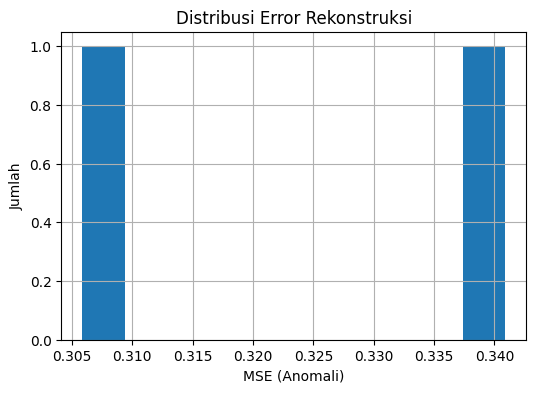

In [18]:
import matplotlib.pyplot as plt

reconstructions = model.predict(X_test)[2]
recon_error = np.mean(np.square(X_test - reconstructions), axis=1)

plt.figure(figsize=(6, 4))
plt.hist(recon_error, bins=10)
plt.title("Distribusi Error Rekonstruksi")
plt.xlabel("MSE (Anomali)")
plt.ylabel("Jumlah")
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


<ipython-input-19-c76c90445983>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=proba, palette="viridis")


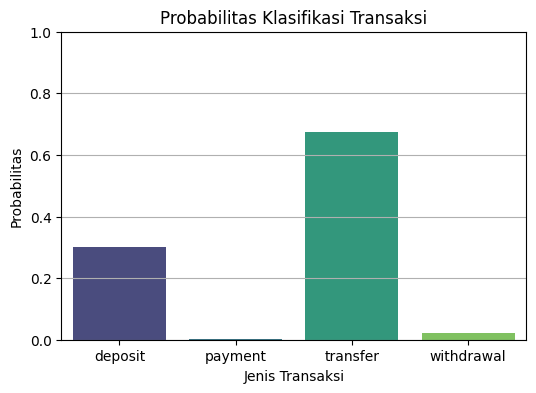

<ipython-input-19-c76c90445983>:34: FutureWarning: The provided callable <function mean at 0x7ca010df9da0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sns.heatmap(df_pred.pivot_table(values="Amount", index="Tipe", aggfunc=np.mean), annot=True, fmt=".2f", cmap="coolwarm")


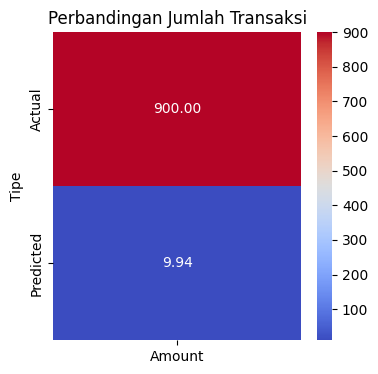

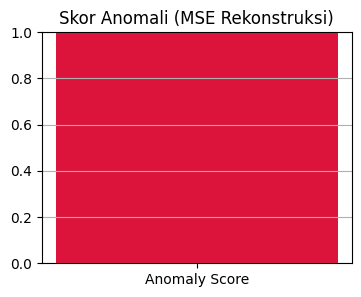

In [19]:
new_data = pd.DataFrame([{
    "amount": 900,
    "balance": 15000,
    "account_type": "savings",
    "vendor": "XYZ Ltd",
    "day": 21,
    "month": 5,
    "year": 2025
}])

X_new = preprocessor.transform(new_data)
prediction = model.predict(X_new)
proba = prediction[0][0]
labels = label_encoder.classes_

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=proba, palette="viridis")
plt.title("Probabilitas Klasifikasi Transaksi")
plt.ylabel("Probabilitas")
plt.xlabel("Jenis Transaksi")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

actual_amount = new_data["amount"].values[0]
predicted_amount = prediction[1][0][0]

df_pred = pd.DataFrame({
    "Tipe": ["Actual", "Predicted"],
    "Amount": [actual_amount, predicted_amount]
})

plt.figure(figsize=(4, 4))
sns.heatmap(df_pred.pivot_table(values="Amount", index="Tipe", aggfunc=np.mean), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Perbandingan Jumlah Transaksi")
plt.show()

recon = prediction[2]
anomaly_score = np.mean(np.square(X_new - recon))

plt.figure(figsize=(4, 3))
plt.bar(["Anomaly Score"], [anomaly_score], color="crimson")
plt.title("Skor Anomali (MSE Rekonstruksi)")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [20]:
import plotly.graph_objects as go

score = anomaly_score

fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=score,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Anomaly Score", 'font': {'size': 24}},
    delta={'reference': 0.2, 'increasing': {'color': "red"}},
    gauge={
        'axis': {'range': [0, 1], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "darkred"},
        'bgcolor': "white",
        'steps': [
            {'range': [0, 0.2], 'color': "green"},
            {'range': [0.2, 0.4], 'color': "yellow"},
            {'range': [0.4, 1], 'color': "red"}
        ],
        'threshold': {
            'line': {'color': "black", 'width': 4},
            'thickness': 0.75,
            'value': 0.4
        }
    }
))

fig.update_layout(height=400)
fig.show()
